# Feasibility problem

Let us consider $M$ balls in $\mathbb{R}^n$, where the $i$-th ball of radius $r_i > 0$ centered in $\mathbf{c}_i \in \mathbb{R}^n$ is given by $\mathcal{B}_i(\mathbf{c}_i, r_i) \subset \mathbb{R}^n$. We are interested in finding a point belonging to their intersection, i.e., we want to solve the following

$$
\begin{equation} 
    \label{eq:intersection}
    \text{find} \ \mathbf{x} \ \text{subject to} \ \mathbf{x} \in \bigcap_{i = 1}^M \mathcal{B}_i(\mathbf{c}_i, r_i)
\end{equation}
$$

It is straightforward to verify that the projection of a point onto $\mathcal{B}_i(\mathbf{c}_i,r_i)$ is evaluated as

$$
\begin{equation}
    \label{eq:projection}
    \mathsf{P}_i(\mathbf{x}) := 
    \text{proj}_{\mathcal{B}_i(\mathbf{c}_i,r_i)}(\mathbf{x}) = 
    \begin{cases}
        \displaystyle r_i\frac{\mathbf{x} - 
        \mathbf{c}_i}{\|\mathbf{x} - \mathbf{c}_i\|} & \text{if} \ \|\mathbf{x} - \mathbf{c}_i\| > r_i \\
        x & \text{otherwise}
    \end{cases}
\end{equation}
$$

Due to the non-expansiveness of the projection in $\eqref{eq:projection}$, one can find a solution for $\eqref{eq:intersection}$ as the fixed point of the following iterate 

$$
\begin{equation}
    \label{eq:krasnoselskii-mann}
    \mathbf{x}_{k+1} = \mathsf{T}(\mathbf{x}_k) = \frac{1}{M}\sum_{i = 1}^M\mathsf{P}_i(\mathbf{x}_k) 
\end{equation}
$$

which result from the well-known Krasnoselskii-Mann iterate. By letting $F = \mathsf{I} - \mathsf{T}$, where $\mathsf{I}$ denotes the identity operator, the fixed point for $\eqref{eq:krasnoselskii-mann}$ can be treated as the canonical VI [1]. 

## References
[1] Bauschke, H. H., & Borwein, J. M. (1996). On projection algorithms for solving convex feasibility problems. SIAM review, 38(3), 367-426.

Using: eg
Using: popov
Using: fbf
Using: frb
Using: prg
Using: eag
Using: arg
Using: graal
Using: agraal
Using: hgraal_1
Using: hgraal_2


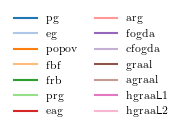

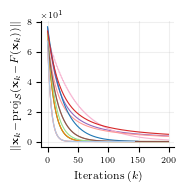

In [4]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from utils import *
from monviso import VI

np.random.seed(2024)

# Problem data
n, M = 1000, 2000
c = np.random.normal(0, 100, size=(M, n))
r = 1 - np.linalg.norm(c, axis=0)

# Projection operator and VI mapping, with its Liptshitz constant
P = lambda x: np.where(
    np.linalg.norm(x - c) > r, r * (x - c) / np.linalg.norm(x - c, axis=0), x
)
F = lambda x: x - P(x).mean(axis=0)
L = 10

# Define the VI
fp = VI(n, F)

# Initial points
x0 = [np.random.rand(n) for _ in range(2)]

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg", "cfogda", "fogda"}).items():
    print(f"Using: {algorithm}")
    sol = fp.solution(
        algorithm,
        params,
        max_iter,
        log_path=f"logs/feasibility/{algorithm}.log",
    )

plot_results(
    "logs/feasibility",
    "figs/feasibility.pdf",
    r"$\|\mathbf{x}_k \! - \! \text{proj}_{\mathcal{S}}(\mathbf{x}_k \! - \! F(\mathbf{x}_k))\|$",
)